In [1]:
from Pointcloud.Modules.Object import Pointcloud
from Pointcloud.Modules.Processor import Processor
from Pointcloud.Modules.Utils import TorchUtils

import matplotlib.pyplot as plt
import meshplot as mp
import torch

In [2]:
pointcloud = Pointcloud.loadObj("cube386.obj")
# pointcloud = Pointcloud.loadObj("cube6146.obj")
# pointcloud = Pointcloud.loadObj("cube24578.obj")
pos = pointcloud.v
processor = Processor(pointcloud)
mel = TorchUtils.averageEdgeLength(pos, processor.graphBuilder.getKNNEdgeIndex(k=6))
gt_c = pos.square().to(torch.int).sum(dim=1)
plot = mp.plot(pos.numpy(), c=gt_c.numpy(), shading={"point_size": mel * 5})
# plot.add_lines(pos.numpy(), (pos + pointcloud.n * 0.1).numpy())

pointcloud = Pointcloud.loadObj("triangle2050.obj")
pos = pointcloud.v
processor = Processor(pointcloud)
mel = TorchUtils.averageEdgeLength(pos, processor.graphBuilder.getKNNEdgeIndex(k=6))
def triangle_GT(pos):
    c_indx0 = pos[:, 1].argmax()
    c_indx1 = pos[:, 0].argmax()
    c_indx2 = pos[:, 0].argmin()
    c_indx3 = pos[:, 2].argmin()
    corner_0 = pos[c_indx0]
    corner_1 = pos[c_indx1]
    corner_2 = pos[c_indx2]
    corner_3 = pos[c_indx3]
    c_01 = (pos - corner_0).norm(dim=1) + (pos - corner_1).norm(dim=1) < (corner_1 - corner_0).norm() + 1e-6
    c_02 = (pos - corner_0).norm(dim=1) + (pos - corner_2).norm(dim=1) < (corner_2 - corner_0).norm() + 1e-6
    c_03 = (pos - corner_0).norm(dim=1) + (pos - corner_3).norm(dim=1) < (corner_3 - corner_0).norm() + 1e-6
    c_12 = (pos - corner_1).norm(dim=1) + (pos - corner_2).norm(dim=1) < (corner_2 - corner_1).norm() + 1e-6
    c_13 = (pos - corner_1).norm(dim=1) + (pos - corner_3).norm(dim=1) < (corner_3 - corner_1).norm() + 1e-6
    c_23 = (pos - corner_2).norm(dim=1) + (pos - corner_3).norm(dim=1) < (corner_3 - corner_2).norm() + 1e-6
    gt_c = (c_01 + c_02 + c_03 + c_12 + c_13 + c_23).to(int)
    gt_c[c_indx0] = 2
    gt_c[c_indx1] = 2
    gt_c[c_indx2] = 2
    gt_c[c_indx3] = 2
    return gt_c
plot = mp.plot(pos.numpy(), c=triangle_GT(pos).numpy(), shading={"point_size": mel * 5})
# plot.add_lines(pos.numpy(), (pos + pointcloud.n * 0.1).numpy())

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [3]:
processor.noise.generateNoise(
    0.1,
    mel,
    0,
    0,
    True
)
processor.graph.edge_index = processor.graphBuilder.getKNNEdgeIndex(k=12)
processor.graphBuilder.setAndFlipNormals(flip=True)
pos = processor.graph.pos
c = (pos - processor.graph.gt).norm(dim=1)
plot = mp.plot(pos.numpy(), c=c.numpy(), shading={"point_size": mel * 2})
plot.add_lines(pos.numpy(), (pos + processor.graph.n * 0.1).numpy())

Creating MST..: 100%|██████████| 24600/24600 [00:00<00:00, 34827.56it/s]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0023940…

1

In [4]:
a = 4
decomposition, _ = processor.getMyFeatureDecomposition(angle = torch.pi * (3*2**(a-1)-1) /  (3*2**a))
classes = decomposition.getClasses()
N = gt_c.size(0)
print((N - (gt_c - 1 == classes).sum()) / N)
print(gt_c.unique(return_counts=True))
print(classes.unique(return_counts=True))
print(N)
print(3*2**a)
_ = mp.plot(processor.graph.gt.numpy(), c=classes.numpy(), shading={"point_size": mel * 5})

RuntimeError: The size of tensor a (386) must match the size of tensor b (2050) at non-singleton dimension 0

Creating MST..:  45%|████▌     | 33519/73752 [00:01<00:01, 21559.51it/s]


KeyboardInterrupt: 

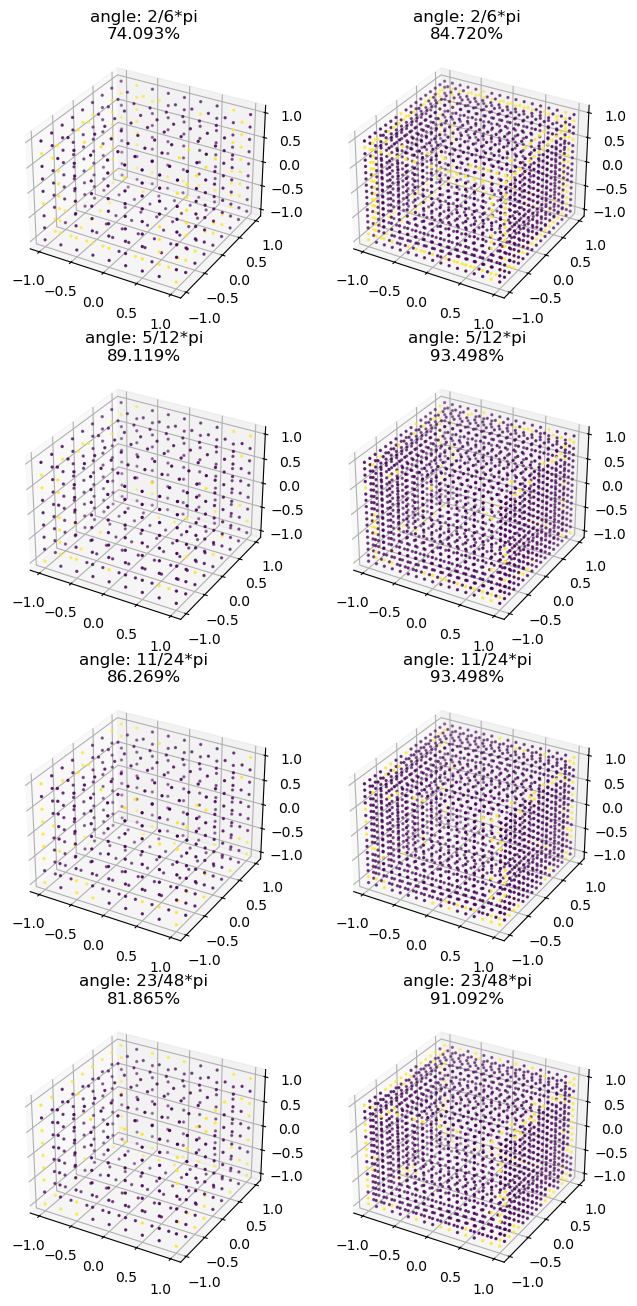

In [ ]:
names = ["cube386.obj", "cube1538.obj", "cube6146.obj", "cube24578.obj"]
pointclouds = [Pointcloud.loadObj(name) for name in names]
poss = [pointcloud.v for pointcloud in pointclouds]
gt_cs = [pos.square().to(torch.int).sum(dim=1) for pos in poss]
processors = [Processor(pointcloud) for pointcloud in pointclouds]

noise_level = 0.3
ass = [1, 2, 3, 4]
size = 4
nrows, ncols = len(ass), len(names)
fig = plt.figure(figsize=(size * ncols, size * nrows))
for i, processor in enumerate(processors):
    _pos = processor.graph.pos
    mel = TorchUtils.averageEdgeLength(
        processor.graph.pos,
        processor.graphBuilder.getKNNEdgeIndex(6)
    )
    processor.noise.generateNoise(
        noise_level,
        mel,
        0,
        0,
        True
    )
    processor.graph.edge_index = processor.graphBuilder.getKNNEdgeIndex(k=12)
    processor.graphBuilder.setAndFlipNormals(flip=True)
    for j, a in enumerate(ass):
        decomposition, _ = processor.getMyFeatureDecomposition(2 ** 4, torch.pi * (3*2**(a-1)-1) /  (3*2**a))
        classes = decomposition.getClasses()
        x = _pos[:, 0].numpy()
        y = _pos[:, 1].numpy()
        z = _pos[:, 2].numpy()
        error = (gt_cs[i] - 1 != classes).numpy()
        ax = fig.add_subplot(nrows, ncols, 1 + i + j*ncols, projection='3d')
        scatter = ax.scatter(x, y, z, c=error, s=2)
        ax.set_title(f"angle: {3*2**(a-1)-1}/{3*2**a}*pi\n{(_pos.size(0) - error.sum()) / _pos.size(0) * 100:.3f}%")

Creating MST..: 100%|██████████| 6168/6168 [00:00<00:00, 36543.51it/s]


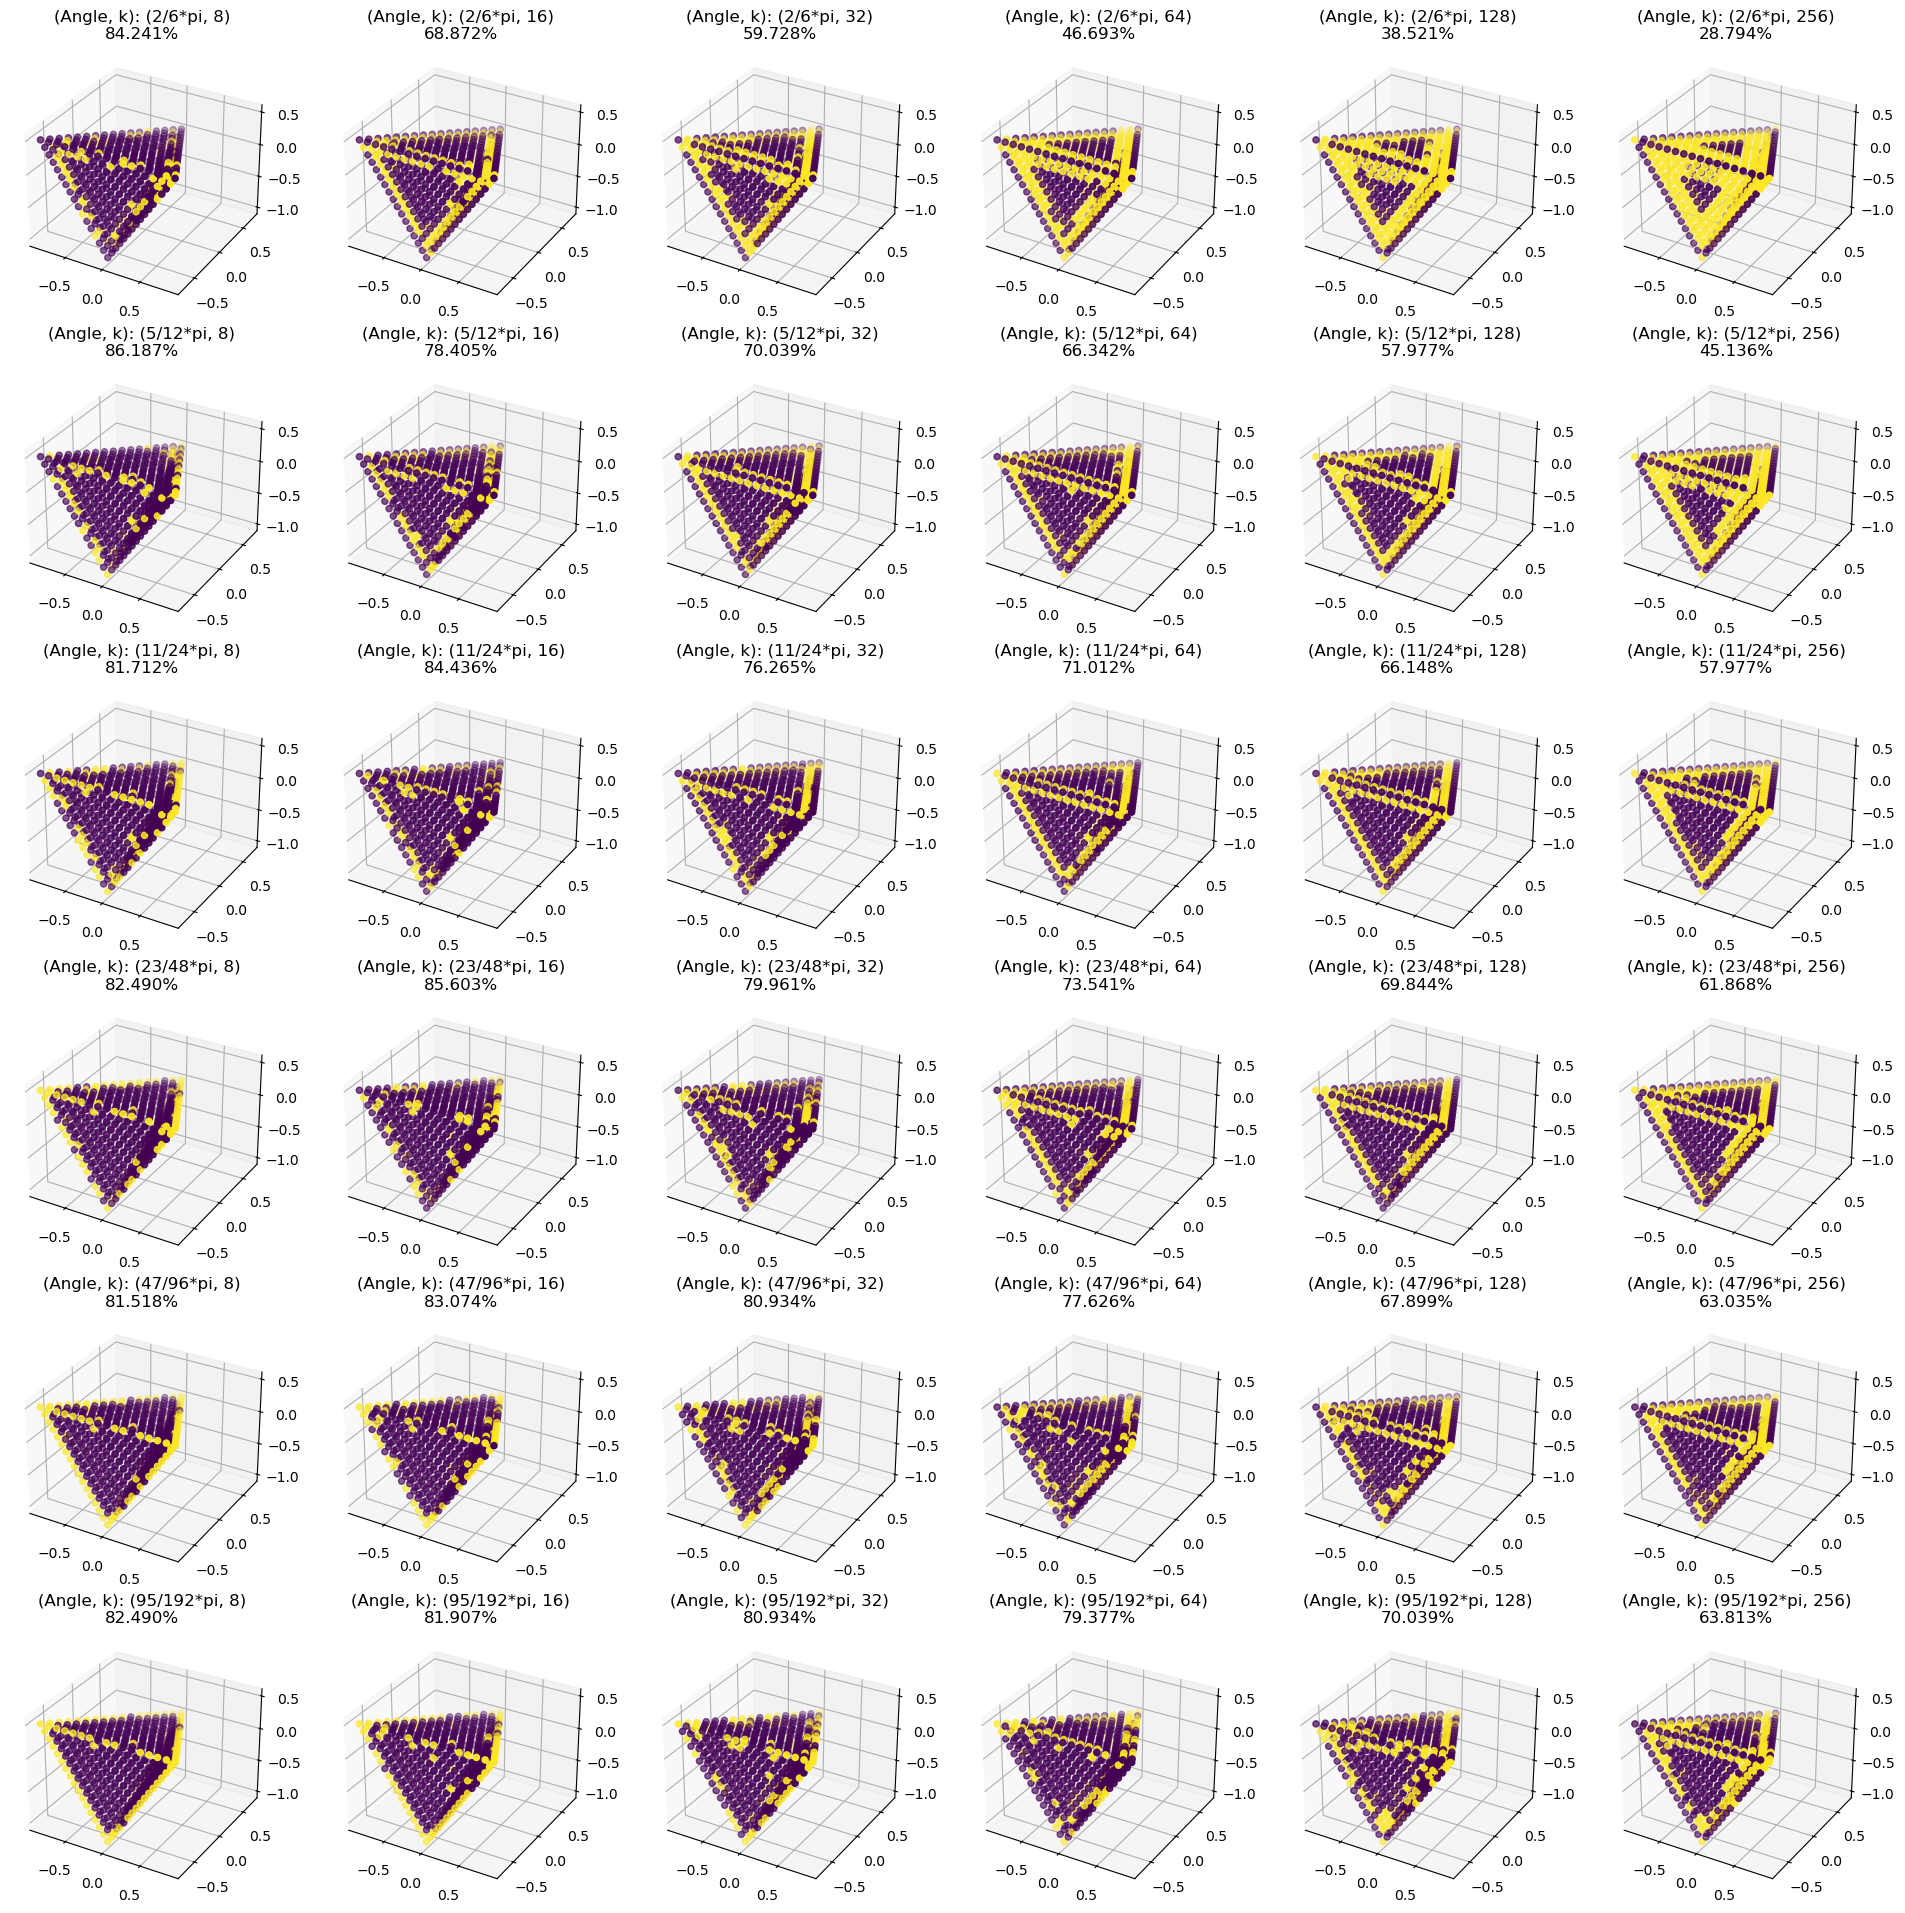

In [ ]:
name = "triangle514.obj"
pointcloud = Pointcloud.loadObj(name)
# gt_c = pointcloud.v.square().to(torch.int).sum(dim=1)
gt_c = triangle_GT(pointcloud.v) + 1
processor = Processor(pointcloud)

noise_level = 0.3
ass = [1, 2, 3, 4, 5, 6]
es = [3, 4, 5, 6, 7, 8]
size = 4
nrows, ncols = len(ass), len(es)
fig = plt.figure(figsize=(size * ncols, size * nrows))
_pos = processor.graph.pos
mel = TorchUtils.averageEdgeLength(
    processor.graph.pos,
    processor.graphBuilder.getKNNEdgeIndex(6)
)
processor.noise.generateNoise(
    noise_level,
    mel,
    0,
    0,
    True
)
processor.graph.edge_index = processor.graphBuilder.getKNNEdgeIndex(k=12)
processor.graphBuilder.setAndFlipNormals(flip=True)
for i, e in enumerate(es):
    for j, a in enumerate(ass):
        decomposition, _ = processor.getMyFeatureDecomposition(2 ** e, torch.pi * (3*2**(a-1)-1) /  (3*2**a))
        classes = decomposition.getClasses()
        x = _pos[:, 0].numpy()
        y = _pos[:, 1].numpy()
        z = _pos[:, 2].numpy()
        error = (gt_c - 1 != classes).numpy()
        ax = fig.add_subplot(nrows, ncols, 1 + i + j*ncols, projection='3d')
        scatter = ax.scatter(x, y, z, c=error, s=20)
        ax.set_title(f"(Angle, k): ({3*2**(a-1)-1}/{3*2**a}*pi, {2 ** e})\n{(_pos.size(0) - error.sum()) / _pos.size(0) * 100:.3f}%")